# # Modelagem 1-dim 64 MFCCs

In [1]:
import keras as K
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from random import choice

from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
DIR_DATAFRAMES = '/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/DATAFRAMES'
DIR_MFCC = '/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC'

In [3]:
!ls -lah $DIR_DATAFRAMES

total 4,1G
drwxrwxrwx 1 hbrandao hbrandao 4,0K mar 21 23:15 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 21 23:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 181K mar 21 23:27 Xfusao.csv
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_0padded.npy
-rwxrwxrwx 1 hbrandao hbrandao 372M mar 23 00:32 Xsinal.npy
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_stretch_0padded.npy
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_tile_0padded.npy


In [4]:
!ls -lahR $DIR_MFCC

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC:
total 0
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:49 .
drwxrwxrwx 1 hbrandao hbrandao 0 mar 21 23:49 ..
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:55 128
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:54 64
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:53 mean

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC/128:
total 944M
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:55 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:10 Xsinal_pad_128mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:10 Xsinal_stretch_128mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:11 Xsinal_tile_128mfcc.npy

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC/64:
total 472M
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:54 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 158M mar 22 02:05 Xsinal_pad_64mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 158M 

In [5]:
PHYS_DEVICE_NAME = tf.config.list_physical_devices('GPU')[0].name[-5:]
if PHYS_DEVICE_NAME:
    print(PHYS_DEVICE_NAME)
else:
    raise Exception('GPU não encontrada')

GPU:0


2023-03-23 03:33:02.329541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 03:33:02.348848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 03:33:02.349000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Dados
___

In [6]:
X64 = np.load(f'{DIR_MFCC}/mean/Xsinal_64mfcc_mean.npy')

x64train, x64test, *_ = train_test_split(X64)
x64train.shape, x64test.shape

((1023, 64), (341, 64))

In [7]:
X128 = np.load(f'{DIR_MFCC}/mean/Xsinal_128mfcc_mean.npy')

x128train, x128test, *_ = train_test_split(X128)
x128train.shape, x128test.shape

((1023, 128), (341, 128))

## Autoencoder
___

In [8]:
dim = X64.shape[-1]

In [9]:
def autoencoder64():
    K.backend.clear_session()

    input64 = K.Input(batch_shape=(1,dim))
    encoder64 = layers.Dense(units=int(dim/2), activation='relu')(input64)
    decoder64 = layers.Dense(units=dim, activation='linear')(encoder64)

    ae64 = K.Model(input64, decoder64, name='autoencoder64')
    ae64.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return ae64

### x64 train

In [10]:
epochs = 1000

es = EarlyStopping(monitor='loss',
                   mode='min',
                   min_delta=0.01,
                   patience=20,
                   verbose=1)

mc = ModelCheckpoint('autoencoder_mean_64mfcc.hdf5',
                     monitor='loss',
                     verbose=1,
                     save_best_only=True,
                     mode='min')

with tf.device(PHYS_DEVICE_NAME):
    K.backend.clear_session()
    modelo64 = autoencoder64()
    history = modelo64.fit(x=x64train,
                           y=x64train,
                           epochs=epochs,
                           batch_size=10,
                           shuffle=True,
                           validation_data=(x64test, x64test),
                           callbacks=[es, mc])

2023-03-23 03:33:02.386077: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 03:33:02.386708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 03:33:02.386936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 03:33:02.387124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/1000
103/103 [==============================] - 1s 2ms/step - loss: 1851.9128 - mae: 17.7867 - val_loss: 535.7184 - val_mae: 10.3310

Epoch 00001: loss improved from inf to 1851.91284, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 2/1000
  1/103 [..............................] - ETA: 0s - loss: 725.0648 - mae: 11.1211

2023-03-23 03:33:03.514159: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


103/103 [==============================] - 0s 1ms/step - loss: 217.7266 - mae: 8.1062 - val_loss: 109.0003 - val_mae: 6.8852

Epoch 00002: loss improved from 1851.91284 to 217.72659, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 3/1000
103/103 [==============================] - 0s 1ms/step - loss: 101.4355 - mae: 6.6101 - val_loss: 86.5292 - val_mae: 6.2454

Epoch 00003: loss improved from 217.72659 to 101.43552, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 4/1000
103/103 [==============================] - 0s 1ms/step - loss: 82.9576 - mae: 6.0694 - val_loss: 73.5553 - val_mae: 5.8151

Epoch 00004: loss improved from 101.43552 to 82.95758, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 5/1000
103/103 [==============================] - 0s 1ms/step - loss: 69.8248 - mae: 5.6556 - val_loss: 61.9688 - val_mae: 5.4459

Epoch 00005: loss improved from 82.95758 to 69.82479, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 6/1000
103/103 [==============================] - 0s 1

103/103 [==============================] - 0s 1ms/step - loss: 11.9521 - mae: 2.5417 - val_loss: 12.5430 - val_mae: 2.6004

Epoch 00037: loss improved from 12.25054 to 11.95214, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 38/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.7101 - mae: 2.5122 - val_loss: 11.9877 - val_mae: 2.5423

Epoch 00038: loss improved from 11.95214 to 11.71007, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 39/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.4793 - mae: 2.4858 - val_loss: 11.7427 - val_mae: 2.5104

Epoch 00039: loss improved from 11.71007 to 11.47933, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 40/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.3140 - mae: 2.4642 - val_loss: 11.5928 - val_mae: 2.4883

Epoch 00040: loss improved from 11.47933 to 11.31405, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 41/1000
103/103 [==============================] - 0s 1ms/st

103/103 [==============================] - 0s 987us/step - loss: 7.2907 - mae: 1.9308 - val_loss: 7.8491 - val_mae: 1.9875

Epoch 00073: loss improved from 7.31476 to 7.29070, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 74/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.2206 - mae: 1.9210 - val_loss: 7.7210 - val_mae: 1.9761

Epoch 00074: loss improved from 7.29070 to 7.22060, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 75/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.1294 - mae: 1.9068 - val_loss: 7.7654 - val_mae: 1.9838

Epoch 00075: loss improved from 7.22060 to 7.12938, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 76/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.1209 - mae: 1.9070 - val_loss: 7.8165 - val_mae: 1.9818

Epoch 00076: loss improved from 7.12938 to 7.12091, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 77/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.0

103/103 [==============================] - 0s 1ms/step - loss: 6.5331 - mae: 1.8146 - val_loss: 7.0446 - val_mae: 1.8779

Epoch 00112: loss did not improve from 6.52754
Epoch 113/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.4790 - mae: 1.8060 - val_loss: 7.0815 - val_mae: 1.8801

Epoch 00113: loss improved from 6.52754 to 6.47902, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 114/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.5202 - mae: 1.8102 - val_loss: 7.0910 - val_mae: 1.8810

Epoch 00114: loss did not improve from 6.47902
Epoch 115/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.5355 - mae: 1.8101 - val_loss: 6.9618 - val_mae: 1.8636

Epoch 00115: loss did not improve from 6.47902
Epoch 116/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.4871 - mae: 1.8058 - val_loss: 7.0512 - val_mae: 1.8886

Epoch 00116: loss did not improve from 6.47902
Epoch 117/1000
103/103 [=====================

103/103 [==============================] - 0s 1ms/step - loss: 6.3096 - mae: 1.7810 - val_loss: 6.8414 - val_mae: 1.8539

Epoch 00153: loss did not improve from 6.28059
Epoch 154/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.3198 - mae: 1.7831 - val_loss: 6.8790 - val_mae: 1.8585

Epoch 00154: loss did not improve from 6.28059
Epoch 155/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2972 - mae: 1.7803 - val_loss: 6.7717 - val_mae: 1.8488

Epoch 00155: loss did not improve from 6.28059
Epoch 156/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.3292 - mae: 1.7863 - val_loss: 6.6742 - val_mae: 1.8198

Epoch 00156: loss did not improve from 6.28059
Epoch 157/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2656 - mae: 1.7754 - val_loss: 6.8509 - val_mae: 1.8516

Epoch 00157: loss improved from 6.28059 to 6.26561, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 158/1000
103/103 [=====================


Epoch 00195: loss did not improve from 6.17887
Epoch 196/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2722 - mae: 1.7855 - val_loss: 6.7809 - val_mae: 1.8498

Epoch 00196: loss did not improve from 6.17887
Epoch 197/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.1719 - mae: 1.7631 - val_loss: 6.7753 - val_mae: 1.8320

Epoch 00197: loss improved from 6.17887 to 6.17189, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 198/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.1511 - mae: 1.7559 - val_loss: 6.7501 - val_mae: 1.8431

Epoch 00198: loss improved from 6.17189 to 6.15114, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 199/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2425 - mae: 1.7712 - val_loss: 6.6059 - val_mae: 1.8295

Epoch 00199: loss did not improve from 6.15114
Epoch 200/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2039 - mae: 1.7718 - val_loss: 6.680

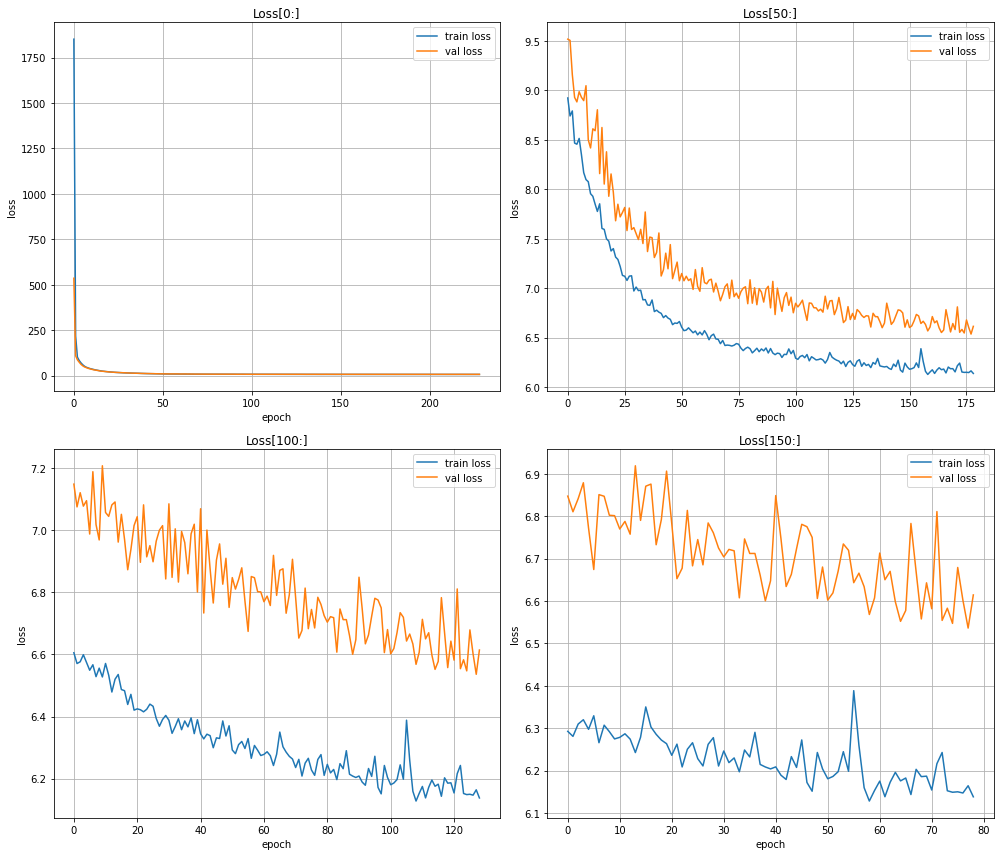

In [11]:
plt.figure(figsize=(14, 12))

row, col = 2, 2

for i,r in enumerate((0, 50, 100, 150)):
    plt.subplot(row,col,i+1)
    plt.plot(history.history['loss'][r:])
    plt.plot(history.history['val_loss'][r:])
    plt.title(f'Loss[{r}:]')
    plt.legend(['train loss', 'val loss'], loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()

plt.tight_layout()
plt.show()

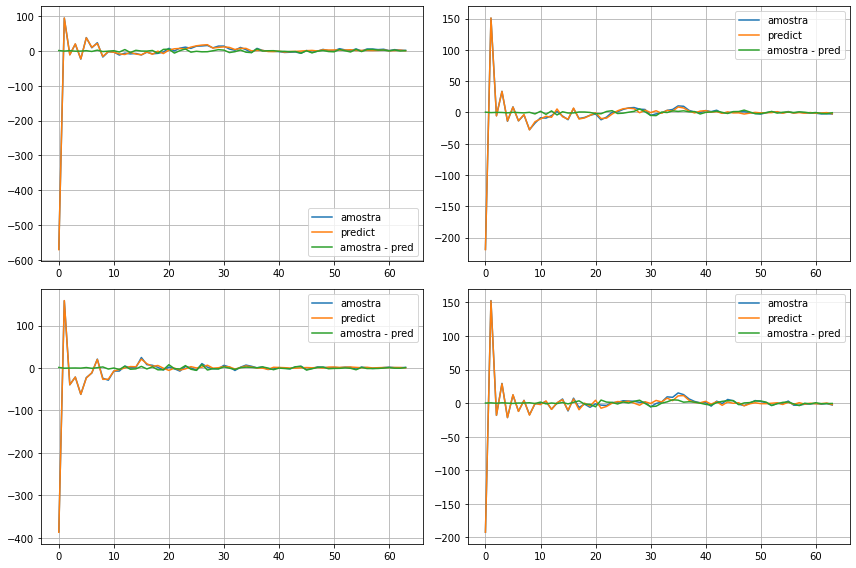

In [12]:
plt.figure(figsize=(12,8))

row, col, idx = 2, 2, 1

for i in range(row*col):
    reg = choice(x64train).reshape(1,dim)
    pred = modelo64.predict(reg)
    diff = reg - pred

    plt.subplot(row, col, idx)
    plt.plot(reg.flatten(), label='amostra')
    plt.plot(pred.flatten(), label='predict')
    plt.plot(diff.flatten(), label='amostra - pred')
    plt.legend()
    plt.grid()
    idx += 1

plt.tight_layout()
plt.show()

In [13]:
pred_x64 = modelo64.predict(x64test)
perda_x64 = K.losses.mse(pred_x64, x64test)

np.mean(perda_x64)

6.6142917

### x64 train MinMax scaled

In [14]:
x64scaled = MinMaxScaler().fit_transform(X64)
x64train_scaled, x64test_scaled, *_ = train_test_split(X64)

x64train_scaled.shape, x64test_scaled.shape

((1023, 64), (341, 64))

In [15]:
epochs = 1000

es = EarlyStopping(monitor='loss',
                   mode='min',
                   min_delta=0.01,
                   patience=20,
                   verbose=1)

mc = ModelCheckpoint('autoencoder_mean_64mfcc_scaled.hdf5',
                     monitor='loss',
                     verbose=1,
                     save_best_only=True,
                     mode='min')

with tf.device(PHYS_DEVICE_NAME):
    K.backend.clear_session()
    modelo64_scaled = autoencoder64()
    history = modelo64_scaled.fit(x=x64train_scaled,
                                  y=x64train_scaled,
                                  epochs=epochs,
                                  batch_size=10,
                                  shuffle=True,
                                  validation_data=(x64test_scaled, x64test_scaled),
                                  callbacks=[es, mc])

Epoch 1/1000
103/103 [==============================] - 0s 1ms/step - loss: 2444.4500 - mae: 19.4602 - val_loss: 1225.4685 - val_mae: 12.1773

Epoch 00001: loss improved from inf to 2444.44995, saving model to autoencoder_mean_64mfcc_scaled.hdf5
Epoch 2/1000
103/103 [==============================] - 0s 1ms/step - loss: 737.7454 - mae: 10.4088 - val_loss: 259.2464 - val_mae: 8.2384

Epoch 00002: loss improved from 2444.44995 to 737.74536, saving model to autoencoder_mean_64mfcc_scaled.hdf5
Epoch 3/1000
103/103 [==============================] - 0s 1ms/step - loss: 178.2166 - mae: 7.6492 - val_loss: 123.3699 - val_mae: 6.8158

Epoch 00003: loss improved from 737.74536 to 178.21655, saving model to autoencoder_mean_64mfcc_scaled.hdf5
Epoch 4/1000
103/103 [==============================] - 0s 1ms/step - loss: 114.5365 - mae: 6.6458 - val_loss: 95.9368 - val_mae: 6.1088

Epoch 00004: loss improved from 178.21655 to 114.53650, saving model to autoencoder_mean_64mfcc_scaled.hdf5
Epoch 5/1000


Epoch 00034: loss improved from 18.36819 to 18.00392, saving model to autoencoder_mean_64mfcc_scaled.hdf5
Epoch 35/1000
103/103 [==============================] - 0s 1ms/step - loss: 17.7412 - mae: 3.0323 - val_loss: 16.8353 - val_mae: 2.9489

Epoch 00035: loss improved from 18.00392 to 17.74117, saving model to autoencoder_mean_64mfcc_scaled.hdf5
Epoch 36/1000
103/103 [==============================] - 0s 1ms/step - loss: 17.4258 - mae: 3.0050 - val_loss: 16.2409 - val_mae: 2.9046

Epoch 00036: loss improved from 17.74117 to 17.42579, saving model to autoencoder_mean_64mfcc_scaled.hdf5
Epoch 37/1000
103/103 [==============================] - 0s 1ms/step - loss: 17.2083 - mae: 2.9869 - val_loss: 16.0662 - val_mae: 2.8788

Epoch 00037: loss improved from 17.42579 to 17.20829, saving model to autoencoder_mean_64mfcc_scaled.hdf5
Epoch 38/1000
103/103 [==============================] - 0s 1ms/step - loss: 16.9511 - mae: 2.9669 - val_loss: 15.9931 - val_mae: 2.8798

Epoch 00038: loss impro

103/103 [==============================] - 0s 1ms/step - loss: 12.4803 - mae: 2.5445 - val_loss: 11.8110 - val_mae: 2.4939

Epoch 00069: loss did not improve from 12.42010
Epoch 70/1000
103/103 [==============================] - 0s 1ms/step - loss: 12.3519 - mae: 2.5297 - val_loss: 11.6985 - val_mae: 2.4758

Epoch 00070: loss improved from 12.42010 to 12.35189, saving model to autoencoder_mean_64mfcc_scaled.hdf5
Epoch 71/1000
103/103 [==============================] - 0s 1ms/step - loss: 12.2684 - mae: 2.5249 - val_loss: 11.8889 - val_mae: 2.4807

Epoch 00071: loss improved from 12.35189 to 12.26844, saving model to autoencoder_mean_64mfcc_scaled.hdf5
Epoch 72/1000
103/103 [==============================] - 0s 1ms/step - loss: 12.4930 - mae: 2.5478 - val_loss: 11.6670 - val_mae: 2.4547

Epoch 00072: loss did not improve from 12.26844
Epoch 73/1000
103/103 [==============================] - 0s 1ms/step - loss: 12.3125 - mae: 2.5224 - val_loss: 11.8060 - val_mae: 2.4713

Epoch 00073: los

103/103 [==============================] - 0s 1ms/step - loss: 11.5694 - mae: 2.4383 - val_loss: 10.9584 - val_mae: 2.3721

Epoch 00107: loss did not improve from 11.51138
Epoch 108/1000
103/103 [==============================] - 0s 983us/step - loss: 11.4727 - mae: 2.4252 - val_loss: 10.9543 - val_mae: 2.3774

Epoch 00108: loss improved from 11.51138 to 11.47266, saving model to autoencoder_mean_64mfcc_scaled.hdf5
Epoch 109/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.4864 - mae: 2.4267 - val_loss: 10.9267 - val_mae: 2.3714

Epoch 00109: loss did not improve from 11.47266
Epoch 110/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.5644 - mae: 2.4331 - val_loss: 10.9852 - val_mae: 2.3762

Epoch 00110: loss did not improve from 11.47266
Epoch 111/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.4534 - mae: 2.4240 - val_loss: 10.8801 - val_mae: 2.3751

Epoch 00111: loss improved from 11.47266 to 11.45339, saving model t

103/103 [==============================] - 0s 1ms/step - loss: 11.2724 - mae: 2.3957 - val_loss: 10.7118 - val_mae: 2.3541

Epoch 00147: loss did not improve from 11.24585
Epoch 148/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.2706 - mae: 2.4007 - val_loss: 10.7017 - val_mae: 2.3477

Epoch 00148: loss did not improve from 11.24585
Epoch 149/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.3120 - mae: 2.4060 - val_loss: 10.6560 - val_mae: 2.3370

Epoch 00149: loss did not improve from 11.24585
Epoch 150/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.2749 - mae: 2.4024 - val_loss: 10.8324 - val_mae: 2.3589

Epoch 00150: loss did not improve from 11.24585
Epoch 151/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.2572 - mae: 2.3988 - val_loss: 11.1468 - val_mae: 2.4060

Epoch 00151: loss did not improve from 11.24585
Epoch 152/1000
103/103 [==============================] - 0s 1ms/step - loss: 11

103/103 [==============================] - 0s 1ms/step - loss: 11.1999 - mae: 2.3965 - val_loss: 10.5540 - val_mae: 2.3399

Epoch 00188: loss did not improve from 11.13541
Epoch 189/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.2415 - mae: 2.4001 - val_loss: 10.5358 - val_mae: 2.3206

Epoch 00189: loss did not improve from 11.13541
Epoch 190/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.1719 - mae: 2.3859 - val_loss: 10.9832 - val_mae: 2.3855

Epoch 00190: loss did not improve from 11.13541
Epoch 191/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.1791 - mae: 2.3890 - val_loss: 10.6248 - val_mae: 2.3417

Epoch 00191: loss did not improve from 11.13541
Epoch 192/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.2063 - mae: 2.3933 - val_loss: 10.7604 - val_mae: 2.3482

Epoch 00192: loss did not improve from 11.13541
Epoch 193/1000
103/103 [==============================] - 0s 1ms/step - loss: 11

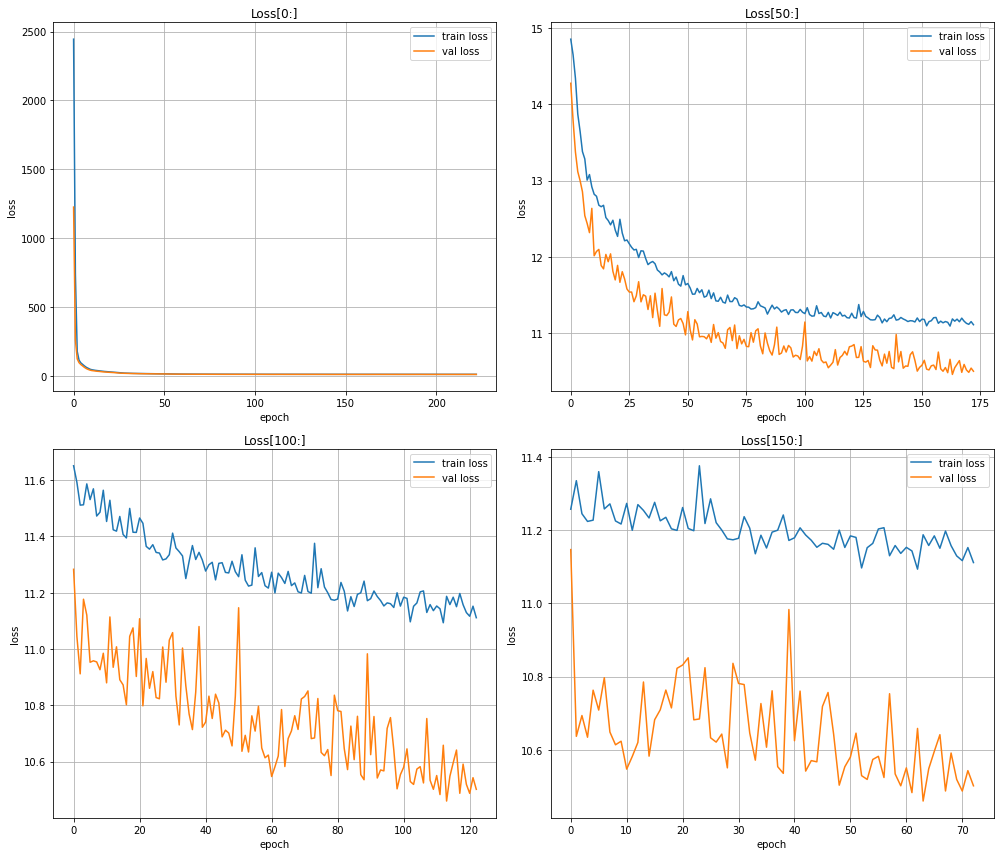

In [16]:
plt.figure(figsize=(14, 12))

row, col = 2, 2

for i,r in enumerate((0, 50, 100, 150)):
    plt.subplot(row,col,i+1)
    plt.plot(history.history['loss'][r:])
    plt.plot(history.history['val_loss'][r:])
    plt.title(f'Loss[{r}:]')
    plt.legend(['train loss', 'val loss'], loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()

plt.tight_layout()
plt.show()

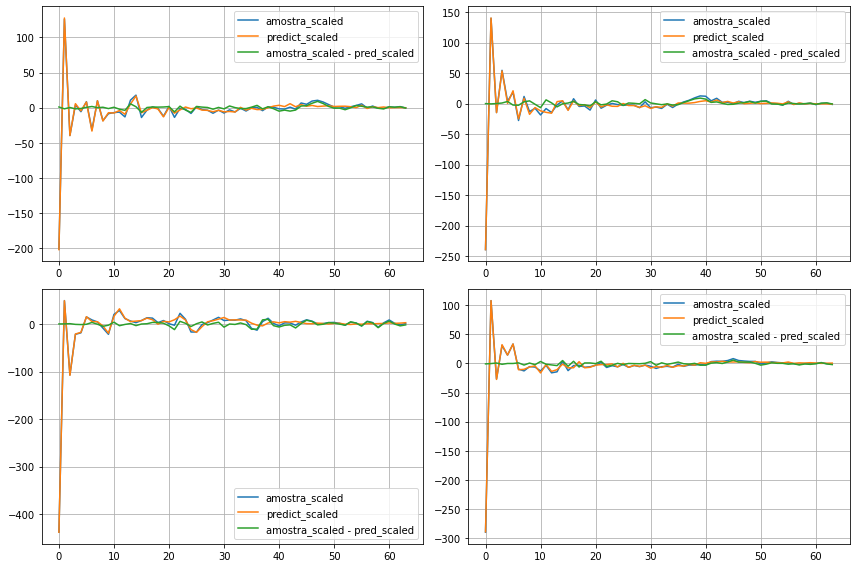

In [17]:
plt.figure(figsize=(12,8))

row, col, idx = 2, 2, 1

for i in range(row*col):
    reg = choice(x64train_scaled).reshape(1,dim)
    pred = modelo64_scaled.predict(reg)
    diff = reg - pred

    plt.subplot(row, col, idx)
    plt.plot(reg.flatten(), label='amostra_scaled')
    plt.plot(pred.flatten(), label='predict_scaled')
    plt.plot(diff.flatten(), label='amostra_scaled - pred_scaled')
    plt.legend()
    plt.grid()
    idx += 1

plt.tight_layout()
plt.show()

In [18]:
pred_x64_scaled = modelo64_scaled.predict(x64test_scaled)
perda_x64_scaled = K.losses.mse(pred_x64_scaled, x64test_scaled)

np.mean(perda_x64_scaled)

10.501751

#### Tentando um Autoencoder mais profundo

In [19]:
def deep_autoencoder64():
    K.backend.clear_session()

    input64 = K.Input(batch_shape=(1,dim))

    encoder64 = layers.Dense(units=int(dim/2), activation='relu')(input64)
    encoder64 = layers.Dropout(0.25)(encoder64)
    encoder64 = layers.Dense(units=int(dim/2), activation='relu')(encoder64)

    decoder64 = layers.Dropout(0.25)(encoder64)
    decoder64 = layers.Dense(units=int(dim/2), activation='relu')(decoder64)
    decoder64 = layers.Dropout(0.25)(decoder64)
    decoder64 = layers.Dense(units=dim, activation='linear')(decoder64)

    ae64 = K.Model(input64, decoder64, name='deep_autoencoder64')
    ae64.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print(ae64.summary())

    return ae64

deep_autoencoder64()

Model: "deep_autoencoder64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 64)]                 0         
_________________________________________________________________
dense (Dense)                (1, 32)                   2080      
_________________________________________________________________
dropout (Dropout)            (1, 32)                   0         
_________________________________________________________________
dense_1 (Dense)              (1, 32)                   1056      
_________________________________________________________________
dropout_1 (Dropout)          (1, 32)                   0         
_________________________________________________________________
dense_2 (Dense)              (1, 32)                   1056      
_________________________________________________________________
dropout_2 (Dropout)          (1, 32)            

In [20]:
epochs = 1000

es = EarlyStopping(monitor='loss',
                   mode='min',
                   min_delta=0.01,
                   patience=20,
                   verbose=1)

mc = ModelCheckpoint('autoencoder_deep_mean_64mfcc.hdf5',
                     monitor='loss',
                     verbose=1,
                     save_best_only=True,
                     mode='min')

with tf.device(PHYS_DEVICE_NAME):
    K.backend.clear_session()
    deep_modelo64 = deep_autoencoder64()
    history = deep_modelo64.fit(x=x64train,
                                y=x64train,
                                epochs=epochs,
                                batch_size=10,
                                shuffle=True,
                                validation_data=(x64test, x64test),
                                callbacks=[es],
                               )

Model: "deep_autoencoder64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 64)]                 0         
_________________________________________________________________
dense (Dense)                (1, 32)                   2080      
_________________________________________________________________
dropout (Dropout)            (1, 32)                   0         
_________________________________________________________________
dense_1 (Dense)              (1, 32)                   1056      
_________________________________________________________________
dropout_1 (Dropout)          (1, 32)                   0         
_________________________________________________________________
dense_2 (Dense)              (1, 32)                   1056      
_________________________________________________________________
dropout_2 (Dropout)          (1, 32)            

Epoch 50/1000
103/103 [==============================] - 0s 1ms/step - loss: 224.6862 - mae: 6.8334 - val_loss: 152.7735 - val_mae: 6.2575
Epoch 51/1000
103/103 [==============================] - 0s 1ms/step - loss: 203.7324 - mae: 6.6781 - val_loss: 177.4642 - val_mae: 6.5672
Epoch 52/1000
103/103 [==============================] - 0s 1ms/step - loss: 214.8448 - mae: 6.7273 - val_loss: 345.5854 - val_mae: 7.4037
Epoch 53/1000
103/103 [==============================] - 0s 1ms/step - loss: 240.4436 - mae: 6.9128 - val_loss: 172.1271 - val_mae: 6.4641
Epoch 54/1000
103/103 [==============================] - 0s 1ms/step - loss: 203.4749 - mae: 6.7395 - val_loss: 331.2365 - val_mae: 7.3245
Epoch 55/1000
103/103 [==============================] - 0s 1ms/step - loss: 193.4749 - mae: 6.6213 - val_loss: 245.7979 - val_mae: 6.9721
Epoch 56/1000
103/103 [==============================] - 0s 1ms/step - loss: 216.2536 - mae: 6.7674 - val_loss: 287.5521 - val_mae: 7.1282
Epoch 57/1000
103/103 [====

In [21]:
np.mean(
    K.losses.mse(deep_modelo64.predict(x64test), x64test)
)

186.02847

Dados os experimentos, podemos assumir que o Autoencoder (`modelo64`) com dados não normalizados apresenta a melhor performance

## Classificador

In [26]:
# DE_PARA_EMOCAO = {
#     'alegria': np.array([1,0,0,0]),
#     'medo': np.array([0,1,0,0]),
#     'raiva': np.array([0,0,1,0]),
#     'surpresa': np.array([0,0,0,1]),
# }

# DE_PARA_INTENSIDADE = {
#     'fraca': np.array([1,0,0,0]),
#     'moderada': np.array([0,1,0,0]),
#     'forte': np.array([0,0,1,0]),
#     'pico': np.array([0,0,0,1]),
# }

# def encoding_emocao(emocao: str):
#     return DE_PARA_EMOCAO.get(emocao)

# def encoding_intensidade(intensidade: str):
#     return DE_PARA_INTENSIDADE.get(intensidade)

## Decomposição

___
Refs:

- [62] https://sci-hub.se/10.1109/tmm.2017.2766843
- [63] https://sci-hub.se/10.1016/j.bspc.2018.08.035
- [64] https://arxiv.org/pdf/1712.08708.pdf
- [65] https://sci-hub.se/10.1109/icassp.2018.8462685
- [66] https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9136653
- [67] https://sci-hub.se/10.1109/ectidamtncon48261.2020.9090768
- [68] https://www.isca-speech.org/archive_v0/Interspeech_2019/pdfs/2561.pdf
- https://sci-hub.se/10.7717/peerj.488
